# Determining the cost of cars

Service for the sale of used cars "Not beaten, not beautiful" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. Based on the technical characteristics, configuration and price of cars, a model was built to determine the cost.

The customer was important:

- quality of prediction;
- prediction speed;
- studying time.

*Basic steps:*
    
1. Download data
2. Data preprocessing
3. Sample preparation for model training
4. Model training
5. Analysis of training time, prediction time and model quality
6. Checking on a test sample

*Notes:*
- To assess the quality of models, it is necessary to apply the RMSE metric.
- The RMSE metric value must be less than 2500.
- Use gradient boosting model.


## Download data

In [1]:
!pip install scikit-learn==1.1.3

In [2]:
!pip install lightgbm


<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>


In [87]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) # make it possible to display all columns on the screen
pd.set_option('display.float_format', '{:.3f}'.format) # display float values up to 3 decimal places
from sklearn.preprocessing import StandardScaler # to scale quantitative features
from sklearn.preprocessing import OrdinalEncoder # ordinal encoding
from sklearn.model_selection import train_test_split # divide by 2 samples
from sklearn.model_selection import GridSearchCV # to find optimal parameters
from sklearn.metrics import mean_squared_error # to calculate MSE and RMSE
from sklearn.metrics import make_scorer #for RMSE
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.ensemble import RandomForestRegressor # random forest
from sklearn.tree import DecisionTreeRegressor # decision tree
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
import time
from sklearn.model_selection import TimeSeriesSplit
import catboost
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
import time
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
RANDOM_STATE = 42
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier

In [2]:
# import data
df = pd.read_csv(r'datasets/10_autos.csv', infer_datetime_format=True)

In [3]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


*Features*

- DateCrawled - date of downloading the profile from the database
- VehicleType - type of car body
- RegistrationYear — year of car registration
- Gearbox - type of gearbox
- Power - power (hp)
- Model - car model
- Kilometer - mileage (km)
- RegistrationMonth — month of car registration
- FuelType — type of fuel
- Brand - car brand
- Repaired - was the car under repair or not
- DateCreated — date of creation of the questionnaire
- NumberOfPictures - the number of photos of the car
- PostalCode - postal code of the owner of the profile (user)
- LastSeen - date of last user activity

*Target feature*
- Price - price (EUR)

In [4]:
# description function
def describe_colums(df):
    
    values = pd.DataFrame()
    
    for col in df.columns:
        values[col] = [df[col].unique(), df[col].dtypes, df[col].nunique(), df[col].isnull().sum().sum(), df.duplicated().sum()]
        
    return values.transpose().sort_values(by=1, ascending=False).rename(
        {0: 'Значения', 1: 'Тип данных', 2: 'Уникальные значения', 3: 'Пропуски', 4: 'Дубликаты'}, axis=1)
describe_colums(df)

,Значения,Тип данных,Уникальные значения,Пропуски,Дубликаты
DateCrawled,"[2016-03-24 11:52:17, 2016-03-24 10:58:45, 201...",object,271174,0,4
VehicleType,"[nan, coupe, suv, small, sedan, convertible, b...",object,8,37490,4
Gearbox,"[manual, auto, nan]",object,2,19833,4
Model,"[golf, nan, grand, fabia, 3er, 2_reihe, other,...",object,250,19705,4
FuelType,"[petrol, gasoline, nan, lpg, other, hybrid, cn...",object,7,32895,4
Brand,"[volkswagen, audi, jeep, skoda, bmw, peugeot, ...",object,40,0,4
Repaired,"[nan, yes, no]",object,2,71154,4
DateCreated,"[2016-03-24 00:00:00, 2016-03-14 00:00:00, 201...",object,109,0,4
LastSeen,"[2016-04-07 03:16:57, 2016-04-07 01:46:50, 201...",object,179150,0,4
Price,"[480, 18300, 9800, 1500, 3600, 650, 2200, 0, 1...",int64,3731,0,4


From the table, the following conclusions can be drawn from the data:
- DateCreated must be in data format
- Passes contain columns VehicleType, Gearbox, Model, FuelType and Repaired
- There are duplicates in the data, but there are few of them among the explicit ones
- NumberOfPictures contains only one unique value, the column can be neglected.
- PostalCode is a personal data about the owner, it does not affect the cost of the car
- DateCrawled, LastSeen don't affect data either
- Some column values ​​are questionable, such as nan in FuelType or "0" in Power

###  Data preprocessing

In [5]:
# drop dublicates
df = df.drop_duplicates(keep='first') 

In [6]:
# cast data column type 'DateCreated' to statistics statistics
df['DateCreated'] = pd.to_datetime(df['DateCreated'])

# convert 'DateCreated' column to date format only year and month
df['DateCreated'] = df['DateCreated'].dt.to_period('M')

In [7]:
# cast the data type of the 'DateCrawled' column to a date type
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])

# convert 'DateCrawled' column to date format only year and month
df['DateCrawled'] = df['DateCrawled'].dt.strftime('%Y-%m')

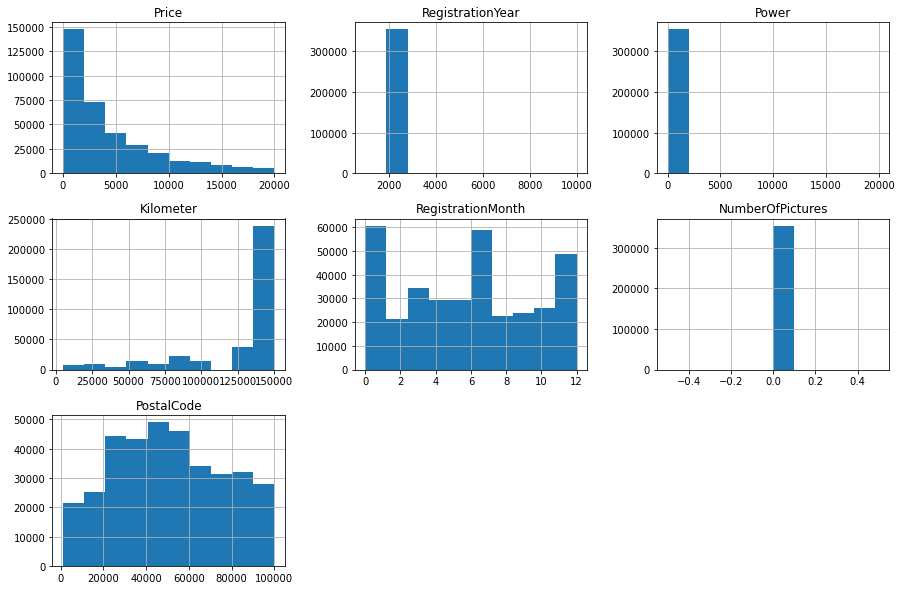

In [8]:
df.hist(figsize=(15, 10));

When plotted graphically, the target column "Price" and "RegistrationYear" are conspicuous.

In the target, the values ​​"0" are not allowed, and there are clearly outliers in the year of registration. Also, 0 values ​​cannot be present in the "Power" column.

### Price column

In [9]:
#number of values "0"
df[df['Price'] <= 100].shape[0]

14345

In [10]:
# remove values less than 100 euros, they are clearly not informative
df = df[df['Price'] > 100]

In [11]:
# check the adequacy of the price on the example of selection for cars older than 2015, with a mileage of less than 10,000 km
df[(df['RegistrationYear'] > 2015) & (df['Kilometer'] < 10000)]['Price'].sort_values(ascending=False).unique()

array([20000, 19999, 19950, 19800, 19750, 19500, 19499, 19490, 19000,
       18950, 18900, 18500, 18400, 18270, 17900, 17800, 17190, 16999,
       16990, 16900, 16850, 16500, 16200, 16000, 15999, 15990, 15950,
       15690, 15500, 15499, 15000, 14900, 14850, 14800, 14590, 14500,
       14290, 13990, 13700, 13600, 13500, 13200, 13000, 12999, 12990,
       12950, 12900, 12800, 12590, 12500, 12499, 12450, 12400, 12000,
       11995, 11990, 11900, 11899, 11625, 11500, 11000, 10990, 10939,
       10625, 10599, 10590, 10500, 10490, 10250,  9999,  9990,  9800,
        9600,  9500,  9300,  9000,  8950,  8900,  8700,  8500,  8490,
        8000,  7990,  7777,  7500,  7000,  6999,  6990,  6950,  6900,
        6800,  6700,  6600,  6500,  6490,  6400,  6350,  6250,  6000,
        5800,  5700,  5550,  5500,  5400,  5399,  5000,  4980,  4900,
        4850,  4800,  4700,  4500,  4400,  4200,  4100,  4000,  3888,
        3750,  3700,  3600,  3500,  3499,  3450,  3400,  3350,  3300,
        3200,  3150,

### Power column

In [12]:
df = df[df['Power'] != 0]

In [13]:
df.nsmallest(10, 'Price')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90696,2016-03,101,small,2015,manual,85,i_reihe,5000,11,petrol,hyundai,no,2016-03,0,93057,2016-03-27 05:15:31
221816,2016-04,101,small,1999,manual,60,corsa,150000,3,petrol,opel,yes,2016-04,0,38302,2016-04-02 15:56:11
332022,2016-03,101,small,2015,manual,86,i_reihe,5000,11,petrol,hyundai,no,2016-03,0,93057,2016-03-24 12:46:18
25683,2016-03,105,wagon,1994,manual,60,golf,5000,0,NaN,volkswagen,NaN,2016-03,0,18236,2016-03-31 06:15:43
114154,2016-03,105,coupe,1997,manual,140,other,150000,0,petrol,renault,yes,2016-03,0,65205,2016-04-06 01:47:10
345547,2016-03,108,small,1997,auto,53,twingo,125000,2,petrol,renault,NaN,2016-03,0,40880,2016-04-04 01:44:39
2594,2016-03,110,small,1995,manual,45,corsa,150000,0,petrol,opel,NaN,2016-03,0,26123,2016-04-01 12:18:28
20814,2016-03,110,wagon,1996,manual,100,astra,150000,2,petrol,opel,no,2016-03,0,71063,2016-04-02 20:46:18
23104,2016-03,110,other,1996,manual,75,golf,150000,1,petrol,volkswagen,yes,2016-03,0,57392,2016-03-21 17:15:43
47394,2016-04,110,sedan,1996,manual,90,mondeo,150000,1,NaN,ford,NaN,2016-04,0,59192,2016-04-03 10:44:14


In [14]:
display(df[(df['Power'] <30)])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
431,2016-03,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03,0,90562,2016-04-03 04:17:08
1235,2016-03,4450,small,1971,manual,23,500,70000,5,petrol,fiat,no,2016-03,0,33729,2016-04-05 18:44:51
1331,2016-04,650,NaN,1970,NaN,26,NaN,100000,5,NaN,trabant,NaN,2016-04,0,9337,2016-04-05 20:45:24
3349,2016-03,1990,small,2004,NaN,7,polo,150000,5,gasoline,volkswagen,no,2016-03,0,37124,2016-04-02 05:16:40
3419,2016-03,2300,NaN,2017,manual,26,601,70000,1,NaN,trabant,no,2016-03,0,39443,2016-04-07 09:45:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351682,2016-03,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN,2016-03,0,16515,2016-04-05 19:47:27
353127,2016-03,8600,convertible,2012,manual,8,NaN,5000,3,gasoline,sonstige_autos,no,2016-03,0,82399,2016-04-06 08:17:29
353447,2016-03,2900,small,1969,manual,18,500,5000,8,petrol,fiat,no,2016-03,0,74076,2016-03-28 17:45:04
353501,2016-03,11300,sedan,1988,manual,29,other,150000,3,petrol,citroen,no,2016-03,0,18347,2016-04-07 09:46:17


In [15]:
display(df[(df['VehicleType'] == "wagon") & (df['Power'] < 50)])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3999,2016-04,1500,wagon,2001,manual,43,agila,150000,1,petrol,opel,no,2016-04,0,39629,2016-04-05 12:38:58
4637,2016-03,870,wagon,2000,manual,16,focus,150000,0,NaN,ford,no,2016-03,0,66693,2016-03-21 08:40:31
6069,2016-03,999,wagon,1991,manual,45,polo,150000,0,petrol,volkswagen,no,2016-03,0,21493,2016-04-07 11:17:36
8195,2016-04,555,wagon,2000,manual,43,kangoo,150000,3,petrol,renault,NaN,2016-04,0,49811,2016-04-04 15:49:29
11746,2016-04,990,wagon,1969,NaN,26,NaN,5000,0,NaN,trabant,NaN,2016-04,0,4758,2016-04-06 02:36:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341242,2016-03,299,wagon,1998,manual,44,other,150000,1,petrol,ford,yes,2016-03,0,70197,2016-03-23 13:45:19
345720,2016-03,2500,wagon,1987,manual,26,601,5000,10,petrol,trabant,no,2016-03,0,1904,2016-04-06 03:16:53
346543,2016-03,2300,wagon,1982,manual,26,601,70000,3,petrol,trabant,no,2016-03,0,98660,2016-04-06 16:16:46
347269,2016-03,450,wagon,1991,manual,45,polo,150000,7,petrol,volkswagen,no,2016-03,0,39167,2016-03-19 08:36:20


In [17]:
# Cars over 400 horsepower are premium supercars, which are outliers for our data
df = df[df['Power'] < 400]
df = df[df['Power'] > 10]

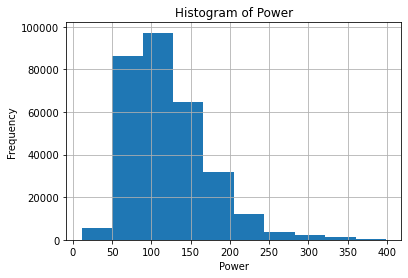

In [19]:
df['Power'].hist()
plt.title('Histogram of Power')
plt.xlabel('Power')
plt.ylabel('Frequency')
plt.show()

There is a slight bias towards low-power cars, which in the case of the economy class segment looks adequate.

### DateCreated column

In [21]:
# display all unique values in the 'DateCrawled' column in descending order
unique_values = df['DateCreated'].sort_values(ascending=False).unique()
print(unique_values)

<PeriodArray>
['2016-04', '2016-03', '2016-02', '2016-01', '2015-12', '2015-11', '2015-09',
 '2015-08', '2015-03']
Length: 9, dtype: period[M]


In [22]:
# display all unique values in the 'DateCrawled' column in descending order
unique_values = df['DateCrawled'].sort_values(ascending=False).unique()
print(unique_values)

['2016-04' '2016-03']


Based on the unique values of the date of creation of the questionnaire, we see that some of the values ​​by years are clearly inadequate. Cars cannot be released later than the date of filling out the questionnaire. Also, less than 1990, cars are suitable only for scrap metal, or this is a rarity, which will be an anomaly.

In [23]:
# remove dates less than 1990 and greater than 2016
df = df[(df['RegistrationYear'] >= 1990) & (df['RegistrationYear'] < 2016)]

In [24]:
# cast the data type of the 'RegistrationYear' column to datetime
df['RegistrationYear'] = pd.to_datetime(df['RegistrationYear'], format='%Y')

In [25]:
df['DateCreated'] = df['DateCreated'].dt.to_timestamp()  # преобразование в datetime64[ns]
display(df.loc[df['RegistrationYear'] > df['DateCreated']])

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


all invalid values removed

Text(0, 0.5, 'Frequency')

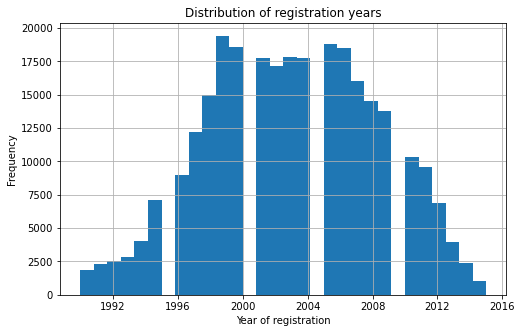

In [26]:
# create a new shape
plt.figure(figsize=(8, 5))

df['RegistrationYear'].hist(bins=30)

# adding a title and labels for the axes
plt.title('Distribution of registration years')
plt.xlabel('Year of registration')
plt.ylabel('Frequency')

# graph display

In [27]:
df['RegistrationYear'] = pd.to_datetime(df['RegistrationYear']).dt.year

In [28]:
df.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-01,0,66954,2016-04-07 01:46:50
2,2016-03,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-01,0,90480,2016-04-05 12:47:46


### Removing uninformative columns

In [29]:
df = df.drop('NumberOfPictures', axis=1)
df = df.drop('PostalCode', axis=1)
df = df.drop('LastSeen', axis=1)
df = df.drop('DateCrawled', axis=1)
df = df.drop('DateCreated', axis=1)

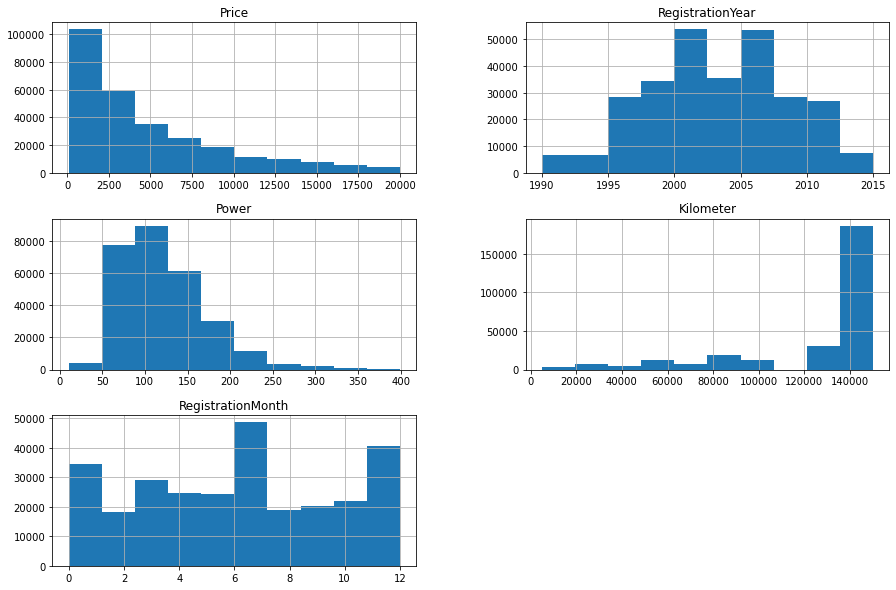

In [30]:
# once again represent the graphical display
df.hist(figsize=(15, 10));

The data looks much better, the price is represented by a graph with a tail to the right, most of the cars belong to the economy segment, this is understandable. The year of production has a normal distribution, the power also has a slight deviation to the right, since the majority of cars are in the range from 50 to 160 hp. Mileage goes by category, all cars with mileage above 140,000 fall into the extreme right part, for used cars this is acceptable. Cars are more often sold in summer or winter, this is also possible.

### Work with releases

In [31]:
#check the data for gaps
def empty_values(df):
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    
    missing_value_df = pd.DataFrame({'Column name': df.columns,
                                     'Missing': count_missing,
                                     '% missing': percent_missing})
    
    return missing_value_df
empty_values(df).sort_values(by='% missing', ascending=False)

,Column name,Missing,% missing
Repaired,Repaired,38148,13.570
FuelType,FuelType,12170,4.330
Model,Model,9213,3.280
Gearbox,Gearbox,4534,1.610
VehicleType,VehicleType,4369,1.550
Price,Price,0,0.000
RegistrationYear,RegistrationYear,0,0.000
Power,Power,0,0.000
Kilometer,Kilometer,0,0.000
RegistrationMonth,RegistrationMonth,0,0.000


In [32]:
df['VehicleType'].value_counts()

sedan          79826
small          68483
wagon          58625
bus            25754
convertible    17877
coupe          13393
suv            10550
other           2203
Name: VehicleType, dtype: int64

In [33]:
df[df['VehicleType'].isnull()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
71,2300,NaN,1997,manual,150,5er,150000,3,NaN,bmw,no
77,800,NaN,2000,manual,90,golf,150000,2,gasoline,volkswagen,NaN
92,250,NaN,2000,NaN,60,ka,150000,0,NaN,ford,NaN
107,900,NaN,1995,manual,90,civic,150000,3,petrol,honda,NaN
233,3750,NaN,2005,NaN,75,golf,150000,0,NaN,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...,...
353836,6666,NaN,2005,auto,170,5er,150000,11,NaN,bmw,no
353855,7200,NaN,2010,manual,131,megane,100000,5,NaN,renault,no
353994,1900,NaN,2000,manual,102,a3,125000,7,petrol,audi,NaN
354049,350,NaN,2000,manual,50,ibiza,150000,5,NaN,seat,no


In [35]:
# filling in data by body type is unnecessarily laborious, just exclude lines with gaps
df.dropna(subset=['VehicleType'], inplace=True)

# same with box model and type - number of rows does not affect dataset (% is negligible)
df['Model'] = df['Model'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')

In [36]:
#fill in the gaps in Repaired with 'no', assuming that if the car was being repaired this would be indicated
df['Repaired'] = df['Repaired'].fillna('no')

In [37]:
# convert the Repaired column to boolean format
df['Repaired'] = df['Repaired'].map({'yes': True, 'no': False})

In [38]:
df['Repaired']

1          True
2         False
3         False
4         False
5          True
          ...  
354359    False
354362     True
354366    False
354367    False
354368    False
Name: Repaired, Length: 276711, dtype: bool

In [39]:
df['Repaired'].value_counts()

False    250633
True      26078
Name: Repaired, dtype: int64

In [41]:
# by default it is assumed that the car is on gasoline
df['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [42]:
df['FuelType'].value_counts()

petrol      175670
gasoline     85476
lpg           4504
cng            465
hybrid         197
electric        59
other           49
Name: FuelType, dtype: int64

In [43]:
df['FuelType'] = df['FuelType'].fillna('petrol')

In [44]:
#check the data for gaps
def empty_values(df):
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    
    missing_value_df = pd.DataFrame({'Column name': df.columns,
                                     'Missing': count_missing,
                                     '% missing': percent_missing})
    
    return missing_value_df
empty_values(df).sort_values(by='% missing', ascending=False)

,Column name,Missing,% missing
Price,Price,0,0.000
VehicleType,VehicleType,0,0.000
RegistrationYear,RegistrationYear,0,0.000
Gearbox,Gearbox,0,0.000
Power,Power,0,0.000
Model,Model,0,0.000
Kilometer,Kilometer,0,0.000
RegistrationMonth,RegistrationMonth,0,0.000
FuelType,FuelType,0,0.000
Brand,Brand,0,0.000


### Correlation check

<AxesSubplot:>

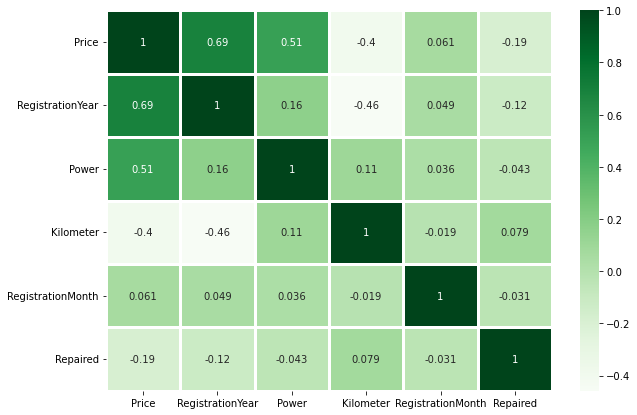

In [45]:
plt.rcParams['figure.figsize'] = (10.0, 7.0)
sns.heatmap(df.corr(), cmap='Greens', annot=True, linewidths=3, linecolor='white')

The data has been preprocessed. We see a direct connection between the price and the year of manufacture of the car and its power. What is standard for the used car market.

So, the main influence on the price is exerted by the year of manufacture of the car and its power.

## Sample preparation for model training

Let's prepare different types of coding.
- OHE (Direct Encoding or One-Hot Encoding)
- OE (ordinal or ordinal encoding)

In [46]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,True
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,False
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,False
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,False
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,True


In [47]:
df['Repaired'].info()

<class 'pandas.core.series.Series'>
Int64Index: 276711 entries, 1 to 354368
Series name: Repaired
Non-Null Count   Dtype
--------------   -----
276711 non-null  bool 
dtypes: bool(1)
memory usage: 2.4 MB


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276711 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              276711 non-null  int64 
 1   VehicleType        276711 non-null  object
 2   RegistrationYear   276711 non-null  int64 
 3   Gearbox            276711 non-null  object
 4   Power              276711 non-null  int64 
 5   Model              276711 non-null  object
 6   Kilometer          276711 non-null  int64 
 7   RegistrationMonth  276711 non-null  int64 
 8   FuelType           276711 non-null  object
 9   Brand              276711 non-null  object
 10  Repaired           276711 non-null  bool  
dtypes: bool(1), int64(5), object(5)
memory usage: 23.5+ MB


In [49]:
features = df.drop(['Price'], axis=1)
target = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [50]:
#numeric signs
#note that 'repaired' is a categorical binary feature
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('Repaired')
num_features

['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

In [51]:
#categorical features for OHE Ridge
ohe_features_ridge = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

#categorical features for OHE RandomForestRegressor
ohe_features_rf = ohe_features_ridge.copy()
ohe_features_rf.remove('Model')
ohe_features_rf

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']


['VehicleType', 'Gearbox', 'FuelType', 'Brand']

In [52]:
X_train_ridge = X_train.copy()
X_test_ridge = X_test.copy()

In [53]:
# the repaired sign is already binary, we won't encode/scale it
# add remainder='passthrough so it doesn't disappear 
col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features_ridge
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# everything is ready in a couple of lines of code
X_train_ridge = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ridge.fit_transform(X_train_ridge),
    columns=col_transformer_ridge.get_feature_names_out()
)

# look at the result
X_train_ridge.head()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,RegistrationYear,Power,Kilometer,RegistrationMonth,Repaired
0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0

In [54]:
# transform the test set
X_test_ridge = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ridge.transform(X_test_ridge),
    columns=col_transformer_ridge.get_feature_names_out()
)

# look at the result
X_test_ridge.head()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,RegistrationYear,Power,Kilometer,RegistrationMonth,Repaired
0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0

In [55]:
# shape check
X_train_ridge.shape, X_test_ridge.shape

((207533, 306), (69178, 306))

In [56]:
# got the same features in the training and test sets
(X_train_ridge.columns != X_test_ridge.columns).sum()

0

## Model training

### model Ridge

In [59]:
# copy training data
X_train_ridge = X_train.copy()

In [60]:
# random_state is not enumerated, we set it directly in the model
model_ridge = Ridge(random_state=RANDOM_STATE)

In [61]:
# Create a new pipeline with a transformer and a trained model
pipeline_ridge = make_pipeline(col_transformer_ridge, model_ridge)
param_grid_ridge = {
    'ridge__alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge_pl = GridSearchCV(
    pipeline_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [62]:
# Measure training time with GridSearchCV
start_time = time.time()
gs_ridge_pl.fit(X_train_ridge, y_train)
training_time_ridge = time.time() - start_time

In [63]:
# Use cross_val_predict to predict on the entire dataset
start_time = time.time()
y_pred_cv = cross_val_predict(pipeline_ridge, features, target, cv=5)
prediction_time_ridge = time.time() - start_time

In [64]:
# Calculate RMSE on the entire dataset
rmse_cv_ridge = mean_squared_error(target, y_pred_cv, squared=False)

In [65]:
print(f'Training time: {training_time_ridge:.4f} seconds')
print(f'Prediction time: {prediction_time_ridge:.4f} seconds')
print(f'RMSE with cross-validation: {rmse_cv_ridge:.4f}')
print(gs_ridge_pl.best_params_)

Training time: 42.4058 seconds
Prediction time: 6.0922 seconds
RMSE with cross-validation: 2196.4479
{'ridge__alpha': 0.18}


### RandomForestRegressor

In [66]:
X_train_rf = X_train.copy()

In [67]:
X_train_rf.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
129409,small,2011,manual,69,other,50000,11,petrol,fiat,False
342263,sedan,2005,auto,116,a_klasse,80000,7,petrol,mercedes_benz,False
106822,sedan,2005,auto,192,x_reihe,150000,9,petrol,bmw,False
11378,sedan,2010,auto,184,5er,150000,10,gasoline,bmw,False
232587,small,2009,manual,77,other,100000,7,petrol,fiat,True


In [68]:
col_transformer_rf= make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        ['Model', 'VehicleType', 'Gearbox', 'FuelType', 'Brand']
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

In [69]:
pipeline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth': range(2, 15),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
}
# it turns out quite a lot of combinations of hyperparameters when iterating
# we will use RandomizedSearchCV, it works much faster
gs_rf = RandomizedSearchCV(
    pipeline_rf, 
    param_distributions=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=RANDOM_STATE,
    error_score='raise'
)

In [70]:
n_jobs = -1
# Measure training time with GridSearchCV
start_time = time.time()
gs_rf.fit(X_train_ridge, y_train)
training_time_rf = time.time() - start_time

In [71]:
n_jobs = -1
# Use cross_val_predict to predict on the entire dataset
start_time = time.time()
y_pred_cv_rf = cross_val_predict(pipeline_rf, features, target, cv=5)
prediction_time_rf = time.time() - start_time

In [72]:
# Calculate RMSE on the entire dataset
rmse_cv_rf = mean_squared_error(target, y_pred_cv_rf, squared=False)

In [73]:
print(f'Training time: {training_time_rf:.4f} seconds')
print(f'Prediction time: {prediction_time_rf:.4f} seconds')
print(f'RMSE with cross-validation: {rmse_cv_rf:.4f}')
print(gs_rf.best_params_)

Training time: 1014.7500 seconds
Prediction time: 388.2318 seconds
RMSE with cross-validation: 1466.3140
{'randomforestregressor__n_estimators': 250, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__max_depth': 12}


### CatBoostRegressor

In [74]:
col_transformer_cbr= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features_rf
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        ['Model']
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)
model = CatBoostRegressor(random_seed=42)

In [75]:
pipeline_cbr = make_pipeline(col_transformer_cbr, model)

param_grid_cbr = {
        'catboostregressor__learning_rate': [0.01, 0.03, 0.1],
        'catboostregressor__depth': range(4, 10),
        'catboostregressor__l2_leaf_reg': [1, 3, 5, 7, 9]
    }

gs_cbr = RandomizedSearchCV(pipeline_cbr,
        param_distributions=param_grid_cbr,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        error_score='raise')

In [76]:
# Measure training time with GridSearchCV
start_time = time.time()
gs_cbr.fit(X_train, y_train)
training_time_cb = time.time() - start_time

0:	learn: 4271.2938710	total: 176ms	remaining: 2m 55s
1:	learn: 3972.2782493	total: 197ms	remaining: 1m 38s
2:	learn: 3709.9269958	total: 217ms	remaining: 1m 11s
3:	learn: 3474.7241424	total: 238ms	remaining: 59.2s
4:	learn: 3271.8572165	total: 259ms	remaining: 51.5s
5:	learn: 3091.6895785	total: 281ms	remaining: 46.6s
6:	learn: 2932.2913532	total: 303ms	remaining: 43s
7:	learn: 2797.5232177	total: 327ms	remaining: 40.5s
8:	learn: 2674.4566586	total: 350ms	remaining: 38.6s
9:	learn: 2569.7464027	total: 374ms	remaining: 37s
10:	learn: 2476.6939196	total: 406ms	remaining: 36.5s
11:	learn: 2393.5981150	total: 433ms	remaining: 35.7s
12:	learn: 2322.9010388	total: 460ms	remaining: 34.9s
13:	learn: 2261.7324377	total: 487ms	remaining: 34.3s
14:	learn: 2206.4601860	total: 515ms	remaining: 33.8s
15:	learn: 2156.8079606	total: 541ms	remaining: 33.3s
16:	learn: 2113.3021988	total: 568ms	remaining: 32.8s
17:	learn: 2073.4166178	total: 595ms	remaining: 32.4s
18:	learn: 2039.1632413	total: 625ms	re

154:	learn: 1542.6111524	total: 5.05s	remaining: 27.5s
155:	learn: 1542.0532948	total: 5.09s	remaining: 27.5s
156:	learn: 1541.1419769	total: 5.13s	remaining: 27.5s
157:	learn: 1540.3855463	total: 5.16s	remaining: 27.5s
158:	learn: 1539.1604204	total: 5.2s	remaining: 27.5s
159:	learn: 1538.5169248	total: 5.23s	remaining: 27.4s
160:	learn: 1537.7524313	total: 5.26s	remaining: 27.4s
161:	learn: 1536.4756584	total: 5.3s	remaining: 27.4s
162:	learn: 1535.9521831	total: 5.33s	remaining: 27.4s
163:	learn: 1535.0034521	total: 5.37s	remaining: 27.3s
164:	learn: 1534.4260349	total: 5.39s	remaining: 27.3s
165:	learn: 1533.9040762	total: 5.42s	remaining: 27.3s
166:	learn: 1532.9375339	total: 5.45s	remaining: 27.2s
167:	learn: 1532.3005042	total: 5.49s	remaining: 27.2s
168:	learn: 1531.5435734	total: 5.51s	remaining: 27.1s
169:	learn: 1530.9261171	total: 5.55s	remaining: 27.1s
170:	learn: 1530.4388458	total: 5.58s	remaining: 27s
171:	learn: 1529.4614211	total: 5.61s	remaining: 27s
172:	learn: 1528

308:	learn: 1461.4717334	total: 9.69s	remaining: 21.7s
309:	learn: 1460.9244527	total: 9.72s	remaining: 21.6s
310:	learn: 1460.5276150	total: 9.75s	remaining: 21.6s
311:	learn: 1459.8680737	total: 9.78s	remaining: 21.6s
312:	learn: 1459.4041683	total: 9.81s	remaining: 21.5s
313:	learn: 1458.7280380	total: 9.84s	remaining: 21.5s
314:	learn: 1458.2227850	total: 9.87s	remaining: 21.5s
315:	learn: 1457.8385313	total: 9.9s	remaining: 21.4s
316:	learn: 1457.4747937	total: 9.93s	remaining: 21.4s
317:	learn: 1457.2346129	total: 9.96s	remaining: 21.4s
318:	learn: 1456.9515417	total: 9.98s	remaining: 21.3s
319:	learn: 1456.7376097	total: 10s	remaining: 21.3s
320:	learn: 1456.4100134	total: 10s	remaining: 21.2s
321:	learn: 1456.1361153	total: 10.1s	remaining: 21.2s
322:	learn: 1455.5795359	total: 10.1s	remaining: 21.2s
323:	learn: 1455.2392182	total: 10.1s	remaining: 21.1s
324:	learn: 1454.9254595	total: 10.2s	remaining: 21.1s
325:	learn: 1454.4562898	total: 10.2s	remaining: 21.1s
326:	learn: 145

459:	learn: 1415.0241468	total: 14s	remaining: 16.4s
460:	learn: 1414.9119495	total: 14s	remaining: 16.4s
461:	learn: 1414.5917921	total: 14s	remaining: 16.4s
462:	learn: 1414.4337252	total: 14.1s	remaining: 16.3s
463:	learn: 1414.3105529	total: 14.1s	remaining: 16.3s
464:	learn: 1413.9787254	total: 14.1s	remaining: 16.3s
465:	learn: 1413.8617259	total: 14.2s	remaining: 16.2s
466:	learn: 1413.7041182	total: 14.2s	remaining: 16.2s
467:	learn: 1413.3511380	total: 14.2s	remaining: 16.2s
468:	learn: 1413.0871180	total: 14.2s	remaining: 16.1s
469:	learn: 1412.8146473	total: 14.3s	remaining: 16.1s
470:	learn: 1412.5889927	total: 14.3s	remaining: 16.1s
471:	learn: 1412.1612405	total: 14.3s	remaining: 16s
472:	learn: 1412.0424800	total: 14.3s	remaining: 16s
473:	learn: 1411.7877829	total: 14.4s	remaining: 16s
474:	learn: 1411.5074870	total: 14.4s	remaining: 15.9s
475:	learn: 1411.1845484	total: 14.4s	remaining: 15.9s
476:	learn: 1410.9343789	total: 14.5s	remaining: 15.9s
477:	learn: 1410.76269

615:	learn: 1380.7613996	total: 18.6s	remaining: 11.6s
616:	learn: 1380.1546944	total: 18.6s	remaining: 11.6s
617:	learn: 1379.8973161	total: 18.7s	remaining: 11.5s
618:	learn: 1379.6641412	total: 18.7s	remaining: 11.5s
619:	learn: 1379.4546770	total: 18.7s	remaining: 11.5s
620:	learn: 1379.2732660	total: 18.8s	remaining: 11.5s
621:	learn: 1379.1020262	total: 18.8s	remaining: 11.4s
622:	learn: 1378.7285049	total: 18.8s	remaining: 11.4s
623:	learn: 1378.4040941	total: 18.9s	remaining: 11.4s
624:	learn: 1378.1318953	total: 18.9s	remaining: 11.3s
625:	learn: 1377.8795663	total: 18.9s	remaining: 11.3s
626:	learn: 1377.4861478	total: 19s	remaining: 11.3s
627:	learn: 1377.4233424	total: 19s	remaining: 11.3s
628:	learn: 1377.2911302	total: 19s	remaining: 11.2s
629:	learn: 1377.1664459	total: 19.1s	remaining: 11.2s
630:	learn: 1376.9517912	total: 19.1s	remaining: 11.2s
631:	learn: 1376.6747111	total: 19.1s	remaining: 11.1s
632:	learn: 1376.4673374	total: 19.2s	remaining: 11.1s
633:	learn: 1376

768:	learn: 1353.6716836	total: 23.6s	remaining: 7.08s
769:	learn: 1353.4063909	total: 23.6s	remaining: 7.05s
770:	learn: 1353.2814169	total: 23.6s	remaining: 7.02s
771:	learn: 1353.1709752	total: 23.7s	remaining: 6.99s
772:	learn: 1353.0587966	total: 23.7s	remaining: 6.95s
773:	learn: 1352.9209264	total: 23.7s	remaining: 6.92s
774:	learn: 1352.7342829	total: 23.7s	remaining: 6.89s
775:	learn: 1352.5994849	total: 23.8s	remaining: 6.86s
776:	learn: 1352.3899655	total: 23.8s	remaining: 6.83s
777:	learn: 1352.2975355	total: 23.8s	remaining: 6.8s
778:	learn: 1352.1730343	total: 23.9s	remaining: 6.77s
779:	learn: 1351.9635114	total: 23.9s	remaining: 6.73s
780:	learn: 1351.8475110	total: 23.9s	remaining: 6.7s
781:	learn: 1351.6594813	total: 23.9s	remaining: 6.67s
782:	learn: 1351.4694269	total: 24s	remaining: 6.64s
783:	learn: 1351.3653332	total: 24s	remaining: 6.61s
784:	learn: 1351.2428234	total: 24s	remaining: 6.58s
785:	learn: 1351.0470246	total: 24s	remaining: 6.55s
786:	learn: 1350.900

924:	learn: 1332.8201804	total: 28.1s	remaining: 2.27s
925:	learn: 1332.7034180	total: 28.1s	remaining: 2.24s
926:	learn: 1332.6294556	total: 28.1s	remaining: 2.21s
927:	learn: 1332.5325315	total: 28.1s	remaining: 2.18s
928:	learn: 1332.4456826	total: 28.2s	remaining: 2.15s
929:	learn: 1332.3102861	total: 28.2s	remaining: 2.12s
930:	learn: 1332.1983111	total: 28.2s	remaining: 2.09s
931:	learn: 1332.0819077	total: 28.3s	remaining: 2.06s
932:	learn: 1331.8901975	total: 28.3s	remaining: 2.03s
933:	learn: 1331.8052050	total: 28.3s	remaining: 2s
934:	learn: 1331.6898935	total: 28.3s	remaining: 1.97s
935:	learn: 1331.6288226	total: 28.4s	remaining: 1.94s
936:	learn: 1331.5592808	total: 28.4s	remaining: 1.91s
937:	learn: 1331.3772374	total: 28.4s	remaining: 1.88s
938:	learn: 1331.2832672	total: 28.5s	remaining: 1.85s
939:	learn: 1331.1990398	total: 28.5s	remaining: 1.82s
940:	learn: 1331.0905292	total: 28.5s	remaining: 1.79s
941:	learn: 1331.0179108	total: 28.5s	remaining: 1.76s
942:	learn: 1

In [77]:
# Use cross_val_predict to predict on the entire dataset
start_time = time.time()
y_pred_cv_cbr = cross_val_predict(pipeline_cbr, features, target, cv=5)
prediction_time_cb = time.time() - start_time

Learning rate set to 0.096097
0:	learn: 4291.7421063	total: 21.4ms	remaining: 21.4s
1:	learn: 4013.7390190	total: 41.7ms	remaining: 20.8s
2:	learn: 3769.3068112	total: 61.2ms	remaining: 20.4s
3:	learn: 3548.7011371	total: 82.2ms	remaining: 20.5s
4:	learn: 3352.7607961	total: 177ms	remaining: 35.3s
5:	learn: 3183.1171184	total: 215ms	remaining: 35.6s
6:	learn: 3032.9791359	total: 238ms	remaining: 33.8s
7:	learn: 2901.1441293	total: 263ms	remaining: 32.6s
8:	learn: 2784.5552596	total: 286ms	remaining: 31.5s
9:	learn: 2686.2935464	total: 313ms	remaining: 31s
10:	learn: 2597.0678656	total: 342ms	remaining: 30.7s
11:	learn: 2517.7239196	total: 367ms	remaining: 30.2s
12:	learn: 2446.7766377	total: 400ms	remaining: 30.4s
13:	learn: 2384.4720021	total: 427ms	remaining: 30.1s
14:	learn: 2330.5335823	total: 453ms	remaining: 29.8s
15:	learn: 2285.1425384	total: 478ms	remaining: 29.4s
16:	learn: 2241.1702139	total: 502ms	remaining: 29s
17:	learn: 2204.9697708	total: 526ms	remaining: 28.7s
18:	lear

157:	learn: 1613.5142408	total: 4.09s	remaining: 21.8s
158:	learn: 1612.6464808	total: 4.12s	remaining: 21.8s
159:	learn: 1611.9839723	total: 4.14s	remaining: 21.7s
160:	learn: 1611.1810504	total: 4.17s	remaining: 21.7s
161:	learn: 1610.2341973	total: 4.19s	remaining: 21.7s
162:	learn: 1609.5506215	total: 4.22s	remaining: 21.7s
163:	learn: 1608.8692586	total: 4.24s	remaining: 21.6s
164:	learn: 1608.2845384	total: 4.27s	remaining: 21.6s
165:	learn: 1607.6851126	total: 4.29s	remaining: 21.6s
166:	learn: 1607.1463575	total: 4.32s	remaining: 21.5s
167:	learn: 1605.9740171	total: 4.34s	remaining: 21.5s
168:	learn: 1605.1159925	total: 4.37s	remaining: 21.5s
169:	learn: 1604.1719587	total: 4.4s	remaining: 21.5s
170:	learn: 1603.4073779	total: 4.44s	remaining: 21.5s
171:	learn: 1602.5838438	total: 4.47s	remaining: 21.5s
172:	learn: 1601.6998375	total: 4.5s	remaining: 21.5s
173:	learn: 1600.7551015	total: 4.54s	remaining: 21.5s
174:	learn: 1600.1922527	total: 4.56s	remaining: 21.5s
175:	learn: 

309:	learn: 1534.3044131	total: 8.18s	remaining: 18.2s
310:	learn: 1534.0235850	total: 8.21s	remaining: 18.2s
311:	learn: 1533.7536677	total: 8.23s	remaining: 18.1s
312:	learn: 1533.3847563	total: 8.27s	remaining: 18.1s
313:	learn: 1533.1338067	total: 8.3s	remaining: 18.1s
314:	learn: 1532.7868801	total: 8.33s	remaining: 18.1s
315:	learn: 1532.5463286	total: 8.35s	remaining: 18.1s
316:	learn: 1532.4488375	total: 8.38s	remaining: 18.1s
317:	learn: 1532.1002073	total: 8.4s	remaining: 18s
318:	learn: 1531.9122609	total: 8.43s	remaining: 18s
319:	learn: 1531.5547214	total: 8.46s	remaining: 18s
320:	learn: 1531.2629943	total: 8.48s	remaining: 17.9s
321:	learn: 1530.9924731	total: 8.51s	remaining: 17.9s
322:	learn: 1530.6324360	total: 8.54s	remaining: 17.9s
323:	learn: 1530.1997567	total: 8.57s	remaining: 17.9s
324:	learn: 1529.8096531	total: 8.6s	remaining: 17.9s
325:	learn: 1529.4997933	total: 8.63s	remaining: 17.8s
326:	learn: 1529.2139023	total: 8.65s	remaining: 17.8s
327:	learn: 1528.96

463:	learn: 1493.8131473	total: 12s	remaining: 13.9s
464:	learn: 1493.5432738	total: 12s	remaining: 13.9s
465:	learn: 1493.4389511	total: 12.1s	remaining: 13.8s
466:	learn: 1493.2830294	total: 12.1s	remaining: 13.8s
467:	learn: 1493.0627133	total: 12.1s	remaining: 13.8s
468:	learn: 1492.6834046	total: 12.1s	remaining: 13.7s
469:	learn: 1492.3903917	total: 12.2s	remaining: 13.7s
470:	learn: 1492.2534861	total: 12.2s	remaining: 13.7s
471:	learn: 1492.0775986	total: 12.2s	remaining: 13.7s
472:	learn: 1491.9889573	total: 12.2s	remaining: 13.6s
473:	learn: 1491.6355969	total: 12.3s	remaining: 13.6s
474:	learn: 1491.4176515	total: 12.3s	remaining: 13.6s
475:	learn: 1491.2319387	total: 12.3s	remaining: 13.5s
476:	learn: 1490.9290099	total: 12.3s	remaining: 13.5s
477:	learn: 1490.7411331	total: 12.3s	remaining: 13.5s
478:	learn: 1490.5031209	total: 12.4s	remaining: 13.5s
479:	learn: 1490.2942265	total: 12.4s	remaining: 13.4s
480:	learn: 1490.1083877	total: 12.4s	remaining: 13.4s
481:	learn: 14

614:	learn: 1465.5398691	total: 15.6s	remaining: 9.76s
615:	learn: 1465.2056851	total: 15.6s	remaining: 9.73s
616:	learn: 1465.0045711	total: 15.6s	remaining: 9.7s
617:	learn: 1464.8808184	total: 15.7s	remaining: 9.68s
618:	learn: 1464.6407000	total: 15.7s	remaining: 9.65s
619:	learn: 1464.4916282	total: 15.7s	remaining: 9.62s
620:	learn: 1464.2506474	total: 15.7s	remaining: 9.59s
621:	learn: 1464.1316079	total: 15.7s	remaining: 9.56s
622:	learn: 1464.0118181	total: 15.8s	remaining: 9.54s
623:	learn: 1463.9195583	total: 15.8s	remaining: 9.51s
624:	learn: 1463.8238190	total: 15.8s	remaining: 9.48s
625:	learn: 1463.6450864	total: 15.8s	remaining: 9.46s
626:	learn: 1463.4874363	total: 15.8s	remaining: 9.43s
627:	learn: 1463.4136677	total: 15.9s	remaining: 9.4s
628:	learn: 1463.1436904	total: 15.9s	remaining: 9.37s
629:	learn: 1463.0380067	total: 15.9s	remaining: 9.34s
630:	learn: 1462.9023479	total: 15.9s	remaining: 9.31s
631:	learn: 1462.7679618	total: 16s	remaining: 9.29s
632:	learn: 14

767:	learn: 1441.5789551	total: 19.3s	remaining: 5.84s
768:	learn: 1441.5083591	total: 19.4s	remaining: 5.82s
769:	learn: 1441.3385305	total: 19.4s	remaining: 5.79s
770:	learn: 1441.2092331	total: 19.4s	remaining: 5.77s
771:	learn: 1441.1283506	total: 19.5s	remaining: 5.75s
772:	learn: 1441.0058451	total: 19.5s	remaining: 5.72s
773:	learn: 1440.8572522	total: 19.5s	remaining: 5.7s
774:	learn: 1440.7753534	total: 19.5s	remaining: 5.67s
775:	learn: 1440.5872391	total: 19.6s	remaining: 5.65s
776:	learn: 1440.4909885	total: 19.6s	remaining: 5.62s
777:	learn: 1440.2727583	total: 19.6s	remaining: 5.6s
778:	learn: 1440.1465247	total: 19.6s	remaining: 5.57s
779:	learn: 1440.0558234	total: 19.7s	remaining: 5.55s
780:	learn: 1439.9989652	total: 19.7s	remaining: 5.52s
781:	learn: 1439.7998165	total: 19.7s	remaining: 5.5s
782:	learn: 1439.5913613	total: 19.8s	remaining: 5.47s
783:	learn: 1439.4609599	total: 19.8s	remaining: 5.45s
784:	learn: 1439.3217262	total: 19.8s	remaining: 5.42s
785:	learn: 1

918:	learn: 1423.4947210	total: 23.2s	remaining: 2.04s
919:	learn: 1423.4249015	total: 23.2s	remaining: 2.02s
920:	learn: 1423.3540230	total: 23.3s	remaining: 2s
921:	learn: 1423.2794891	total: 23.3s	remaining: 1.97s
922:	learn: 1423.0859796	total: 23.3s	remaining: 1.95s
923:	learn: 1422.9477126	total: 23.3s	remaining: 1.92s
924:	learn: 1422.7958713	total: 23.4s	remaining: 1.9s
925:	learn: 1422.7215059	total: 23.4s	remaining: 1.87s
926:	learn: 1422.5757337	total: 23.4s	remaining: 1.84s
927:	learn: 1422.5093495	total: 23.5s	remaining: 1.82s
928:	learn: 1422.4058868	total: 23.5s	remaining: 1.79s
929:	learn: 1422.2357194	total: 23.5s	remaining: 1.77s
930:	learn: 1422.1569409	total: 23.5s	remaining: 1.74s
931:	learn: 1421.9876512	total: 23.6s	remaining: 1.72s
932:	learn: 1421.9274938	total: 23.6s	remaining: 1.69s
933:	learn: 1421.8574830	total: 23.6s	remaining: 1.67s
934:	learn: 1421.7975923	total: 23.6s	remaining: 1.64s
935:	learn: 1421.6112385	total: 23.6s	remaining: 1.62s
936:	learn: 14

76:	learn: 1713.5079164	total: 1.87s	remaining: 22.4s
77:	learn: 1711.7080197	total: 1.89s	remaining: 22.4s
78:	learn: 1709.5036110	total: 1.92s	remaining: 22.4s
79:	learn: 1707.1434148	total: 1.94s	remaining: 22.3s
80:	learn: 1705.3597699	total: 1.96s	remaining: 22.3s
81:	learn: 1703.7020989	total: 1.98s	remaining: 22.2s
82:	learn: 1701.8793549	total: 2s	remaining: 22.2s
83:	learn: 1700.6997917	total: 2.03s	remaining: 22.1s
84:	learn: 1699.2423957	total: 2.05s	remaining: 22s
85:	learn: 1697.3289279	total: 2.07s	remaining: 22s
86:	learn: 1696.1343443	total: 2.09s	remaining: 22s
87:	learn: 1694.7239895	total: 2.11s	remaining: 21.9s
88:	learn: 1693.3886796	total: 2.14s	remaining: 21.9s
89:	learn: 1691.9558513	total: 2.16s	remaining: 21.8s
90:	learn: 1690.8842931	total: 2.18s	remaining: 21.8s
91:	learn: 1689.4820765	total: 2.2s	remaining: 21.8s
92:	learn: 1687.8872167	total: 2.23s	remaining: 21.7s
93:	learn: 1686.3426083	total: 2.25s	remaining: 21.7s
94:	learn: 1684.9362475	total: 2.27s	r

230:	learn: 1564.7220687	total: 5.59s	remaining: 18.6s
231:	learn: 1564.0529799	total: 5.61s	remaining: 18.6s
232:	learn: 1563.2767747	total: 5.63s	remaining: 18.5s
233:	learn: 1562.8380828	total: 5.66s	remaining: 18.5s
234:	learn: 1562.4437035	total: 5.68s	remaining: 18.5s
235:	learn: 1562.1309533	total: 5.7s	remaining: 18.5s
236:	learn: 1561.7329604	total: 5.72s	remaining: 18.4s
237:	learn: 1561.2850619	total: 5.75s	remaining: 18.4s
238:	learn: 1560.8569521	total: 5.77s	remaining: 18.4s
239:	learn: 1560.4941552	total: 5.79s	remaining: 18.3s
240:	learn: 1559.9686631	total: 5.82s	remaining: 18.3s
241:	learn: 1559.6772332	total: 5.84s	remaining: 18.3s
242:	learn: 1559.1883086	total: 5.86s	remaining: 18.3s
243:	learn: 1558.6640665	total: 5.88s	remaining: 18.2s
244:	learn: 1558.2412985	total: 5.91s	remaining: 18.2s
245:	learn: 1557.3442931	total: 5.93s	remaining: 18.2s
246:	learn: 1556.9320914	total: 5.95s	remaining: 18.1s
247:	learn: 1556.2516180	total: 5.98s	remaining: 18.1s
248:	learn:

385:	learn: 1508.7402819	total: 9.79s	remaining: 15.6s
386:	learn: 1508.3241411	total: 9.82s	remaining: 15.6s
387:	learn: 1508.0902140	total: 9.85s	remaining: 15.5s
388:	learn: 1507.8440794	total: 9.88s	remaining: 15.5s
389:	learn: 1507.6349612	total: 9.9s	remaining: 15.5s
390:	learn: 1507.4078640	total: 9.93s	remaining: 15.5s
391:	learn: 1507.1367022	total: 9.96s	remaining: 15.5s
392:	learn: 1507.0159539	total: 9.99s	remaining: 15.4s
393:	learn: 1506.5959836	total: 10s	remaining: 15.4s
394:	learn: 1506.3243015	total: 10s	remaining: 15.4s
395:	learn: 1506.1169766	total: 10.1s	remaining: 15.4s
396:	learn: 1505.8396188	total: 10.1s	remaining: 15.3s
397:	learn: 1505.5545114	total: 10.1s	remaining: 15.3s
398:	learn: 1505.3062699	total: 10.2s	remaining: 15.3s
399:	learn: 1505.0741604	total: 10.2s	remaining: 15.3s
400:	learn: 1504.6714525	total: 10.2s	remaining: 15.3s
401:	learn: 1504.2510425	total: 10.3s	remaining: 15.3s
402:	learn: 1503.9860696	total: 10.3s	remaining: 15.2s
403:	learn: 150

544:	learn: 1472.7270864	total: 14s	remaining: 11.7s
545:	learn: 1472.4313644	total: 14s	remaining: 11.7s
546:	learn: 1472.1714381	total: 14.1s	remaining: 11.6s
547:	learn: 1472.0318855	total: 14.1s	remaining: 11.6s
548:	learn: 1471.7257605	total: 14.1s	remaining: 11.6s
549:	learn: 1471.6043141	total: 14.1s	remaining: 11.6s
550:	learn: 1471.4010599	total: 14.1s	remaining: 11.5s
551:	learn: 1471.2035595	total: 14.2s	remaining: 11.5s
552:	learn: 1470.8877754	total: 14.2s	remaining: 11.5s
553:	learn: 1470.7338266	total: 14.2s	remaining: 11.4s
554:	learn: 1470.5825356	total: 14.2s	remaining: 11.4s
555:	learn: 1470.3876567	total: 14.3s	remaining: 11.4s
556:	learn: 1470.2046763	total: 14.3s	remaining: 11.4s
557:	learn: 1470.1193054	total: 14.3s	remaining: 11.3s
558:	learn: 1469.8966329	total: 14.3s	remaining: 11.3s
559:	learn: 1469.6088697	total: 14.4s	remaining: 11.3s
560:	learn: 1469.5242885	total: 14.4s	remaining: 11.2s
561:	learn: 1469.2887476	total: 14.4s	remaining: 11.2s
562:	learn: 14

696:	learn: 1448.4992190	total: 17.7s	remaining: 7.68s
697:	learn: 1448.4119160	total: 17.7s	remaining: 7.66s
698:	learn: 1448.3127782	total: 17.7s	remaining: 7.63s
699:	learn: 1448.1285404	total: 17.7s	remaining: 7.6s
700:	learn: 1448.0269074	total: 17.8s	remaining: 7.58s
701:	learn: 1447.6747462	total: 17.8s	remaining: 7.55s
702:	learn: 1447.5281187	total: 17.8s	remaining: 7.53s
703:	learn: 1447.3447789	total: 17.8s	remaining: 7.5s
704:	learn: 1447.2220439	total: 17.9s	remaining: 7.47s
705:	learn: 1447.0767293	total: 17.9s	remaining: 7.45s
706:	learn: 1447.0067628	total: 17.9s	remaining: 7.42s
707:	learn: 1446.8771718	total: 17.9s	remaining: 7.39s
708:	learn: 1446.6874415	total: 18s	remaining: 7.37s
709:	learn: 1446.4938439	total: 18s	remaining: 7.34s
710:	learn: 1446.4217643	total: 18s	remaining: 7.32s
711:	learn: 1446.3167664	total: 18s	remaining: 7.29s
712:	learn: 1446.1998626	total: 18s	remaining: 7.26s
713:	learn: 1446.0951904	total: 18.1s	remaining: 7.24s
714:	learn: 1445.95197

851:	learn: 1427.7315403	total: 21.2s	remaining: 3.69s
852:	learn: 1427.3363767	total: 21.2s	remaining: 3.66s
853:	learn: 1427.2254333	total: 21.3s	remaining: 3.63s
854:	learn: 1427.1733990	total: 21.3s	remaining: 3.61s
855:	learn: 1427.0946163	total: 21.3s	remaining: 3.58s
856:	learn: 1427.0028371	total: 21.3s	remaining: 3.56s
857:	learn: 1426.8540940	total: 21.4s	remaining: 3.53s
858:	learn: 1426.6619621	total: 21.4s	remaining: 3.51s
859:	learn: 1426.6023745	total: 21.4s	remaining: 3.48s
860:	learn: 1426.4106741	total: 21.4s	remaining: 3.46s
861:	learn: 1426.3407897	total: 21.5s	remaining: 3.44s
862:	learn: 1426.1862454	total: 21.5s	remaining: 3.41s
863:	learn: 1426.0868986	total: 21.5s	remaining: 3.38s
864:	learn: 1425.8329644	total: 21.5s	remaining: 3.36s
865:	learn: 1425.7160194	total: 21.6s	remaining: 3.33s
866:	learn: 1425.6199044	total: 21.6s	remaining: 3.31s
867:	learn: 1425.5189502	total: 21.6s	remaining: 3.29s
868:	learn: 1425.3263359	total: 21.6s	remaining: 3.26s
869:	learn

6:	learn: 3033.5813108	total: 170ms	remaining: 24.2s
7:	learn: 2898.2801744	total: 193ms	remaining: 23.9s
8:	learn: 2781.1367999	total: 215ms	remaining: 23.7s
9:	learn: 2677.6164419	total: 236ms	remaining: 23.4s
10:	learn: 2588.0036600	total: 259ms	remaining: 23.3s
11:	learn: 2512.8074849	total: 281ms	remaining: 23.1s
12:	learn: 2443.0619541	total: 302ms	remaining: 22.9s
13:	learn: 2381.7658002	total: 324ms	remaining: 22.8s
14:	learn: 2328.0116142	total: 350ms	remaining: 23s
15:	learn: 2282.2306021	total: 376ms	remaining: 23.1s
16:	learn: 2239.0649915	total: 401ms	remaining: 23.2s
17:	learn: 2200.9747949	total: 427ms	remaining: 23.3s
18:	learn: 2167.3053355	total: 452ms	remaining: 23.3s
19:	learn: 2138.2836189	total: 474ms	remaining: 23.3s
20:	learn: 2110.3253782	total: 501ms	remaining: 23.4s
21:	learn: 2085.8899552	total: 527ms	remaining: 23.4s
22:	learn: 2064.1353288	total: 556ms	remaining: 23.6s
23:	learn: 2041.3575492	total: 585ms	remaining: 23.8s
24:	learn: 2017.6917408	total: 619

160:	learn: 1604.5532041	total: 4.03s	remaining: 21s
161:	learn: 1603.8282488	total: 4.07s	remaining: 21s
162:	learn: 1602.8236598	total: 4.09s	remaining: 21s
163:	learn: 1601.8745140	total: 4.12s	remaining: 21s
164:	learn: 1601.2120576	total: 4.14s	remaining: 20.9s
165:	learn: 1600.5462868	total: 4.16s	remaining: 20.9s
166:	learn: 1599.5268086	total: 4.18s	remaining: 20.9s
167:	learn: 1598.8841785	total: 4.21s	remaining: 20.8s
168:	learn: 1597.9847097	total: 4.23s	remaining: 20.8s
169:	learn: 1597.4268654	total: 4.25s	remaining: 20.8s
170:	learn: 1596.7969983	total: 4.28s	remaining: 20.8s
171:	learn: 1595.9082477	total: 4.31s	remaining: 20.7s
172:	learn: 1595.3171520	total: 4.33s	remaining: 20.7s
173:	learn: 1594.4580562	total: 4.35s	remaining: 20.7s
174:	learn: 1593.8282151	total: 4.37s	remaining: 20.6s
175:	learn: 1593.4344981	total: 4.4s	remaining: 20.6s
176:	learn: 1592.7431904	total: 4.42s	remaining: 20.6s
177:	learn: 1592.0274688	total: 4.47s	remaining: 20.6s
178:	learn: 1591.26

310:	learn: 1527.8742113	total: 7.84s	remaining: 17.4s
311:	learn: 1527.5684206	total: 7.87s	remaining: 17.3s
312:	learn: 1527.1835653	total: 7.89s	remaining: 17.3s
313:	learn: 1526.8109079	total: 7.91s	remaining: 17.3s
314:	learn: 1526.4008272	total: 7.93s	remaining: 17.3s
315:	learn: 1525.9136230	total: 7.96s	remaining: 17.2s
316:	learn: 1525.4465086	total: 7.98s	remaining: 17.2s
317:	learn: 1525.1022694	total: 8s	remaining: 17.2s
318:	learn: 1524.9264940	total: 8.02s	remaining: 17.1s
319:	learn: 1524.6392767	total: 8.04s	remaining: 17.1s
320:	learn: 1524.1742542	total: 8.07s	remaining: 17.1s
321:	learn: 1523.9180766	total: 8.09s	remaining: 17s
322:	learn: 1523.4984957	total: 8.12s	remaining: 17s
323:	learn: 1523.2335441	total: 8.14s	remaining: 17s
324:	learn: 1522.9504657	total: 8.16s	remaining: 16.9s
325:	learn: 1522.6729533	total: 8.18s	remaining: 16.9s
326:	learn: 1522.3428255	total: 8.2s	remaining: 16.9s
327:	learn: 1522.1057547	total: 8.22s	remaining: 16.9s
328:	learn: 1521.847

462:	learn: 1484.4850087	total: 11.5s	remaining: 13.3s
463:	learn: 1484.3317964	total: 11.5s	remaining: 13.3s
464:	learn: 1484.0974418	total: 11.5s	remaining: 13.3s
465:	learn: 1483.8283068	total: 11.6s	remaining: 13.3s
466:	learn: 1483.6655835	total: 11.6s	remaining: 13.2s
467:	learn: 1483.4412975	total: 11.6s	remaining: 13.2s
468:	learn: 1483.2684814	total: 11.6s	remaining: 13.2s
469:	learn: 1483.0215269	total: 11.7s	remaining: 13.1s
470:	learn: 1482.7812153	total: 11.7s	remaining: 13.1s
471:	learn: 1482.4558989	total: 11.7s	remaining: 13.1s
472:	learn: 1482.1926452	total: 11.7s	remaining: 13.1s
473:	learn: 1481.9617260	total: 11.7s	remaining: 13s
474:	learn: 1481.7286280	total: 11.8s	remaining: 13s
475:	learn: 1481.5185707	total: 11.8s	remaining: 13s
476:	learn: 1481.4136492	total: 11.8s	remaining: 13s
477:	learn: 1481.2759872	total: 11.8s	remaining: 12.9s
478:	learn: 1481.1767774	total: 11.9s	remaining: 12.9s
479:	learn: 1480.9804081	total: 11.9s	remaining: 12.9s
480:	learn: 1480.6

620:	learn: 1455.4757661	total: 15.6s	remaining: 9.54s
621:	learn: 1455.2470709	total: 15.7s	remaining: 9.52s
622:	learn: 1455.1616023	total: 15.7s	remaining: 9.49s
623:	learn: 1455.0378042	total: 15.7s	remaining: 9.47s
624:	learn: 1454.9557345	total: 15.7s	remaining: 9.45s
625:	learn: 1454.8116771	total: 15.8s	remaining: 9.42s
626:	learn: 1454.6752171	total: 15.8s	remaining: 9.4s
627:	learn: 1454.4759493	total: 15.8s	remaining: 9.38s
628:	learn: 1454.3644609	total: 15.9s	remaining: 9.36s
629:	learn: 1454.2790014	total: 15.9s	remaining: 9.33s
630:	learn: 1454.1658616	total: 15.9s	remaining: 9.31s
631:	learn: 1454.0260201	total: 15.9s	remaining: 9.28s
632:	learn: 1453.8371248	total: 16s	remaining: 9.26s
633:	learn: 1453.7255725	total: 16s	remaining: 9.23s
634:	learn: 1453.6512243	total: 16s	remaining: 9.2s
635:	learn: 1453.4764022	total: 16s	remaining: 9.18s
636:	learn: 1453.3585026	total: 16.1s	remaining: 9.15s
637:	learn: 1453.2607279	total: 16.1s	remaining: 9.13s
638:	learn: 1453.099

776:	learn: 1433.4735650	total: 19.6s	remaining: 5.61s
777:	learn: 1433.3750807	total: 19.6s	remaining: 5.58s
778:	learn: 1433.2118184	total: 19.6s	remaining: 5.56s
779:	learn: 1433.0943536	total: 19.6s	remaining: 5.53s
780:	learn: 1433.0019842	total: 19.6s	remaining: 5.51s
781:	learn: 1432.9048231	total: 19.7s	remaining: 5.48s
782:	learn: 1432.7800218	total: 19.7s	remaining: 5.46s
783:	learn: 1432.6819306	total: 19.7s	remaining: 5.43s
784:	learn: 1432.5875456	total: 19.7s	remaining: 5.41s
785:	learn: 1432.3757712	total: 19.8s	remaining: 5.38s
786:	learn: 1432.2899050	total: 19.8s	remaining: 5.36s
787:	learn: 1432.2305120	total: 19.8s	remaining: 5.33s
788:	learn: 1432.1547401	total: 19.8s	remaining: 5.3s
789:	learn: 1432.0292528	total: 19.9s	remaining: 5.28s
790:	learn: 1431.8938412	total: 19.9s	remaining: 5.25s
791:	learn: 1431.7517037	total: 19.9s	remaining: 5.23s
792:	learn: 1431.6745681	total: 19.9s	remaining: 5.2s
793:	learn: 1431.5160097	total: 19.9s	remaining: 5.17s
794:	learn: 

929:	learn: 1415.6617138	total: 23.2s	remaining: 1.75s
930:	learn: 1415.5941705	total: 23.2s	remaining: 1.72s
931:	learn: 1415.4997332	total: 23.3s	remaining: 1.7s
932:	learn: 1415.4349632	total: 23.3s	remaining: 1.67s
933:	learn: 1415.3278470	total: 23.3s	remaining: 1.65s
934:	learn: 1415.1756652	total: 23.3s	remaining: 1.62s
935:	learn: 1415.0478765	total: 23.3s	remaining: 1.6s
936:	learn: 1414.9968045	total: 23.4s	remaining: 1.57s
937:	learn: 1414.8509468	total: 23.4s	remaining: 1.55s
938:	learn: 1414.7766336	total: 23.4s	remaining: 1.52s
939:	learn: 1414.7226142	total: 23.4s	remaining: 1.5s
940:	learn: 1414.5983187	total: 23.5s	remaining: 1.47s
941:	learn: 1414.4841281	total: 23.5s	remaining: 1.45s
942:	learn: 1414.4326702	total: 23.5s	remaining: 1.42s
943:	learn: 1414.3548627	total: 23.5s	remaining: 1.4s
944:	learn: 1414.2776157	total: 23.6s	remaining: 1.37s
945:	learn: 1414.1488937	total: 23.6s	remaining: 1.35s
946:	learn: 1414.0814369	total: 23.6s	remaining: 1.32s
947:	learn: 14

86:	learn: 1699.1620294	total: 2.17s	remaining: 22.8s
87:	learn: 1697.6114155	total: 2.19s	remaining: 22.7s
88:	learn: 1695.2217613	total: 2.22s	remaining: 22.7s
89:	learn: 1693.3625873	total: 2.25s	remaining: 22.7s
90:	learn: 1692.2355471	total: 2.27s	remaining: 22.7s
91:	learn: 1690.6077276	total: 2.3s	remaining: 22.7s
92:	learn: 1689.3821648	total: 2.33s	remaining: 22.7s
93:	learn: 1687.9538954	total: 2.35s	remaining: 22.7s
94:	learn: 1686.0163129	total: 2.38s	remaining: 22.6s
95:	learn: 1684.6851908	total: 2.41s	remaining: 22.7s
96:	learn: 1683.7765063	total: 2.43s	remaining: 22.6s
97:	learn: 1682.2119360	total: 2.45s	remaining: 22.6s
98:	learn: 1681.0662786	total: 2.48s	remaining: 22.5s
99:	learn: 1679.9685246	total: 2.5s	remaining: 22.5s
100:	learn: 1678.1045992	total: 2.53s	remaining: 22.5s
101:	learn: 1676.9365422	total: 2.55s	remaining: 22.5s
102:	learn: 1674.9674593	total: 2.58s	remaining: 22.4s
103:	learn: 1673.4361087	total: 2.61s	remaining: 22.5s
104:	learn: 1672.7286396	t

239:	learn: 1566.7836648	total: 6.19s	remaining: 19.6s
240:	learn: 1566.2883270	total: 6.22s	remaining: 19.6s
241:	learn: 1565.9657510	total: 6.24s	remaining: 19.6s
242:	learn: 1565.7052490	total: 6.27s	remaining: 19.5s
243:	learn: 1565.2773549	total: 6.29s	remaining: 19.5s
244:	learn: 1564.6405789	total: 6.32s	remaining: 19.5s
245:	learn: 1563.9688642	total: 6.35s	remaining: 19.5s
246:	learn: 1563.4620859	total: 6.38s	remaining: 19.4s
247:	learn: 1562.8968239	total: 6.4s	remaining: 19.4s
248:	learn: 1562.3835857	total: 6.42s	remaining: 19.4s
249:	learn: 1561.8874421	total: 6.45s	remaining: 19.3s
250:	learn: 1561.2380554	total: 6.47s	remaining: 19.3s
251:	learn: 1560.8417638	total: 6.49s	remaining: 19.3s
252:	learn: 1560.4248162	total: 6.51s	remaining: 19.2s
253:	learn: 1560.0736918	total: 6.54s	remaining: 19.2s
254:	learn: 1559.7138315	total: 6.56s	remaining: 19.2s
255:	learn: 1559.3283165	total: 6.58s	remaining: 19.1s
256:	learn: 1559.1218633	total: 6.6s	remaining: 19.1s
257:	learn: 

396:	learn: 1513.5319932	total: 10.1s	remaining: 15.3s
397:	learn: 1513.2424721	total: 10.1s	remaining: 15.3s
398:	learn: 1513.0209785	total: 10.1s	remaining: 15.2s
399:	learn: 1512.7447610	total: 10.1s	remaining: 15.2s
400:	learn: 1512.5169904	total: 10.2s	remaining: 15.2s
401:	learn: 1512.2456214	total: 10.2s	remaining: 15.1s
402:	learn: 1512.0488030	total: 10.2s	remaining: 15.1s
403:	learn: 1511.7030856	total: 10.2s	remaining: 15.1s
404:	learn: 1511.4835768	total: 10.2s	remaining: 15.1s
405:	learn: 1511.2628279	total: 10.3s	remaining: 15s
406:	learn: 1510.6883777	total: 10.3s	remaining: 15s
407:	learn: 1510.5144240	total: 10.3s	remaining: 15s
408:	learn: 1510.2916989	total: 10.3s	remaining: 14.9s
409:	learn: 1510.0541507	total: 10.4s	remaining: 14.9s
410:	learn: 1509.8670672	total: 10.4s	remaining: 14.9s
411:	learn: 1509.7042505	total: 10.4s	remaining: 14.8s
412:	learn: 1509.1325226	total: 10.4s	remaining: 14.8s
413:	learn: 1508.9626300	total: 10.4s	remaining: 14.8s
414:	learn: 1508

551:	learn: 1480.0783296	total: 13.6s	remaining: 11.1s
552:	learn: 1479.9715053	total: 13.7s	remaining: 11s
553:	learn: 1479.8220443	total: 13.7s	remaining: 11s
554:	learn: 1479.5801752	total: 13.7s	remaining: 11s
555:	learn: 1479.4139550	total: 13.7s	remaining: 11s
556:	learn: 1479.2928857	total: 13.7s	remaining: 10.9s
557:	learn: 1479.1229980	total: 13.8s	remaining: 10.9s
558:	learn: 1478.8394664	total: 13.8s	remaining: 10.9s
559:	learn: 1478.7332084	total: 13.8s	remaining: 10.8s
560:	learn: 1478.6177716	total: 13.8s	remaining: 10.8s
561:	learn: 1478.4986028	total: 13.8s	remaining: 10.8s
562:	learn: 1478.3673666	total: 13.9s	remaining: 10.8s
563:	learn: 1478.2332790	total: 13.9s	remaining: 10.7s
564:	learn: 1478.0739165	total: 13.9s	remaining: 10.7s
565:	learn: 1477.8564966	total: 13.9s	remaining: 10.7s
566:	learn: 1477.6701289	total: 14s	remaining: 10.7s
567:	learn: 1477.5424632	total: 14s	remaining: 10.6s
568:	learn: 1477.3002686	total: 14s	remaining: 10.6s
569:	learn: 1477.0980787

702:	learn: 1456.3733120	total: 17s	remaining: 7.2s
703:	learn: 1456.1654237	total: 17.1s	remaining: 7.17s
704:	learn: 1456.1067882	total: 17.1s	remaining: 7.15s
705:	learn: 1456.0126145	total: 17.1s	remaining: 7.12s
706:	learn: 1455.8996190	total: 17.1s	remaining: 7.1s
707:	learn: 1455.8394473	total: 17.2s	remaining: 7.07s
708:	learn: 1455.7182165	total: 17.2s	remaining: 7.05s
709:	learn: 1455.6372522	total: 17.2s	remaining: 7.03s
710:	learn: 1455.5261200	total: 17.2s	remaining: 7s
711:	learn: 1455.4628783	total: 17.2s	remaining: 6.97s
712:	learn: 1455.3259705	total: 17.3s	remaining: 6.95s
713:	learn: 1455.2436932	total: 17.3s	remaining: 6.92s
714:	learn: 1455.1471143	total: 17.3s	remaining: 6.9s
715:	learn: 1455.0018179	total: 17.3s	remaining: 6.88s
716:	learn: 1454.8603057	total: 17.4s	remaining: 6.85s
717:	learn: 1454.6940617	total: 17.4s	remaining: 6.83s
718:	learn: 1454.5523321	total: 17.4s	remaining: 6.8s
719:	learn: 1454.4643045	total: 17.4s	remaining: 6.78s
720:	learn: 1454.37

858:	learn: 1436.5776953	total: 21s	remaining: 3.45s
859:	learn: 1436.4836738	total: 21.1s	remaining: 3.43s
860:	learn: 1436.3865057	total: 21.1s	remaining: 3.4s
861:	learn: 1436.2732520	total: 21.1s	remaining: 3.38s
862:	learn: 1436.2372343	total: 21.1s	remaining: 3.35s
863:	learn: 1436.1064086	total: 21.2s	remaining: 3.33s
864:	learn: 1436.0233280	total: 21.2s	remaining: 3.31s
865:	learn: 1435.8152452	total: 21.2s	remaining: 3.29s
866:	learn: 1435.7274256	total: 21.3s	remaining: 3.26s
867:	learn: 1435.5786252	total: 21.3s	remaining: 3.24s
868:	learn: 1435.5233794	total: 21.3s	remaining: 3.21s
869:	learn: 1435.4127992	total: 21.4s	remaining: 3.19s
870:	learn: 1435.3107988	total: 21.4s	remaining: 3.17s
871:	learn: 1435.2239859	total: 21.4s	remaining: 3.14s
872:	learn: 1435.1153230	total: 21.4s	remaining: 3.12s
873:	learn: 1435.0080188	total: 21.5s	remaining: 3.09s
874:	learn: 1434.8638286	total: 21.5s	remaining: 3.07s
875:	learn: 1434.7740143	total: 21.5s	remaining: 3.04s
876:	learn: 1

16:	learn: 2243.9393741	total: 372ms	remaining: 21.5s
17:	learn: 2206.4820005	total: 395ms	remaining: 21.5s
18:	learn: 2173.6959807	total: 416ms	remaining: 21.5s
19:	learn: 2146.0680266	total: 438ms	remaining: 21.5s
20:	learn: 2112.2271664	total: 462ms	remaining: 21.5s
21:	learn: 2083.5164044	total: 486ms	remaining: 21.6s
22:	learn: 2060.6686475	total: 509ms	remaining: 21.6s
23:	learn: 2039.9233948	total: 533ms	remaining: 21.7s
24:	learn: 2018.4056777	total: 558ms	remaining: 21.7s
25:	learn: 2000.6850160	total: 582ms	remaining: 21.8s
26:	learn: 1984.3784557	total: 605ms	remaining: 21.8s
27:	learn: 1969.0136003	total: 629ms	remaining: 21.8s
28:	learn: 1956.6851707	total: 650ms	remaining: 21.8s
29:	learn: 1944.6605578	total: 673ms	remaining: 21.8s
30:	learn: 1932.4321159	total: 698ms	remaining: 21.8s
31:	learn: 1922.1903169	total: 722ms	remaining: 21.9s
32:	learn: 1911.2413094	total: 747ms	remaining: 21.9s
33:	learn: 1902.0931472	total: 771ms	remaining: 21.9s
34:	learn: 1890.0226273	tota

170:	learn: 1604.9460940	total: 4.04s	remaining: 19.6s
171:	learn: 1604.1053362	total: 4.06s	remaining: 19.6s
172:	learn: 1603.6195286	total: 4.08s	remaining: 19.5s
173:	learn: 1603.0065710	total: 4.11s	remaining: 19.5s
174:	learn: 1602.4981760	total: 4.13s	remaining: 19.5s
175:	learn: 1601.7126995	total: 4.15s	remaining: 19.4s
176:	learn: 1600.7584286	total: 4.17s	remaining: 19.4s
177:	learn: 1600.2046412	total: 4.19s	remaining: 19.4s
178:	learn: 1599.1300458	total: 4.22s	remaining: 19.3s
179:	learn: 1598.4987509	total: 4.24s	remaining: 19.3s
180:	learn: 1597.8640378	total: 4.26s	remaining: 19.3s
181:	learn: 1597.3120474	total: 4.29s	remaining: 19.3s
182:	learn: 1596.6547971	total: 4.31s	remaining: 19.2s
183:	learn: 1595.9702148	total: 4.33s	remaining: 19.2s
184:	learn: 1595.3162945	total: 4.35s	remaining: 19.2s
185:	learn: 1594.4783014	total: 4.38s	remaining: 19.1s
186:	learn: 1593.5945397	total: 4.4s	remaining: 19.1s
187:	learn: 1592.9622089	total: 4.42s	remaining: 19.1s
188:	learn:

322:	learn: 1533.4910614	total: 7.47s	remaining: 15.7s
323:	learn: 1533.1401200	total: 7.49s	remaining: 15.6s
324:	learn: 1532.7178539	total: 7.52s	remaining: 15.6s
325:	learn: 1532.4821448	total: 7.54s	remaining: 15.6s
326:	learn: 1532.2351019	total: 7.57s	remaining: 15.6s
327:	learn: 1532.0096722	total: 7.59s	remaining: 15.6s
328:	learn: 1531.7820666	total: 7.62s	remaining: 15.5s
329:	learn: 1531.3331618	total: 7.64s	remaining: 15.5s
330:	learn: 1530.8492978	total: 7.67s	remaining: 15.5s
331:	learn: 1530.5938352	total: 7.7s	remaining: 15.5s
332:	learn: 1530.2080014	total: 7.72s	remaining: 15.5s
333:	learn: 1529.9942322	total: 7.75s	remaining: 15.4s
334:	learn: 1529.5888771	total: 7.77s	remaining: 15.4s
335:	learn: 1528.8540710	total: 7.8s	remaining: 15.4s
336:	learn: 1528.5699655	total: 7.82s	remaining: 15.4s
337:	learn: 1528.2696056	total: 7.85s	remaining: 15.4s
338:	learn: 1527.9288270	total: 7.87s	remaining: 15.3s
339:	learn: 1527.6339699	total: 7.9s	remaining: 15.3s
340:	learn: 1

478:	learn: 1491.5333965	total: 11.4s	remaining: 12.5s
479:	learn: 1491.4006292	total: 11.5s	remaining: 12.4s
480:	learn: 1491.0172367	total: 11.5s	remaining: 12.4s
481:	learn: 1490.8070951	total: 11.5s	remaining: 12.4s
482:	learn: 1490.6995563	total: 11.5s	remaining: 12.4s
483:	learn: 1490.4111940	total: 11.6s	remaining: 12.3s
484:	learn: 1490.2663912	total: 11.6s	remaining: 12.3s
485:	learn: 1489.9358116	total: 11.6s	remaining: 12.3s
486:	learn: 1489.7457670	total: 11.7s	remaining: 12.3s
487:	learn: 1489.4387826	total: 11.7s	remaining: 12.3s
488:	learn: 1489.1976036	total: 11.7s	remaining: 12.2s
489:	learn: 1488.9906633	total: 11.7s	remaining: 12.2s
490:	learn: 1488.8442542	total: 11.8s	remaining: 12.2s
491:	learn: 1488.5952059	total: 11.8s	remaining: 12.2s
492:	learn: 1488.3656391	total: 11.8s	remaining: 12.2s
493:	learn: 1488.1366810	total: 11.9s	remaining: 12.1s
494:	learn: 1487.9523139	total: 11.9s	remaining: 12.1s
495:	learn: 1487.8398298	total: 11.9s	remaining: 12.1s
496:	learn

629:	learn: 1462.8252960	total: 15.3s	remaining: 8.99s
630:	learn: 1462.7055165	total: 15.3s	remaining: 8.96s
631:	learn: 1462.5864844	total: 15.3s	remaining: 8.94s
632:	learn: 1462.4399491	total: 15.4s	remaining: 8.91s
633:	learn: 1462.2112202	total: 15.4s	remaining: 8.89s
634:	learn: 1462.0439953	total: 15.4s	remaining: 8.86s
635:	learn: 1461.8992208	total: 15.4s	remaining: 8.84s
636:	learn: 1461.8298967	total: 15.5s	remaining: 8.81s
637:	learn: 1461.7191310	total: 15.5s	remaining: 8.79s
638:	learn: 1461.5985257	total: 15.5s	remaining: 8.76s
639:	learn: 1461.4924351	total: 15.5s	remaining: 8.74s
640:	learn: 1461.3055552	total: 15.6s	remaining: 8.71s
641:	learn: 1461.1429104	total: 15.6s	remaining: 8.69s
642:	learn: 1460.7987005	total: 15.6s	remaining: 8.66s
643:	learn: 1460.6265691	total: 15.6s	remaining: 8.64s
644:	learn: 1460.4242530	total: 15.6s	remaining: 8.61s
645:	learn: 1460.2389992	total: 15.7s	remaining: 8.59s
646:	learn: 1459.9836367	total: 15.7s	remaining: 8.56s
647:	learn

785:	learn: 1441.1257962	total: 18.9s	remaining: 5.15s
786:	learn: 1441.0604661	total: 18.9s	remaining: 5.13s
787:	learn: 1440.9112344	total: 19s	remaining: 5.1s
788:	learn: 1440.7305323	total: 19s	remaining: 5.08s
789:	learn: 1440.6669043	total: 19s	remaining: 5.05s
790:	learn: 1440.5707770	total: 19s	remaining: 5.03s
791:	learn: 1440.4040524	total: 19s	remaining: 5s
792:	learn: 1440.3455678	total: 19.1s	remaining: 4.98s
793:	learn: 1440.2538927	total: 19.1s	remaining: 4.95s
794:	learn: 1440.1292369	total: 19.1s	remaining: 4.93s
795:	learn: 1439.9448092	total: 19.1s	remaining: 4.9s
796:	learn: 1439.7563250	total: 19.2s	remaining: 4.88s
797:	learn: 1439.6533984	total: 19.2s	remaining: 4.86s
798:	learn: 1439.4665069	total: 19.2s	remaining: 4.83s
799:	learn: 1439.3825107	total: 19.2s	remaining: 4.81s
800:	learn: 1439.2891183	total: 19.2s	remaining: 4.78s
801:	learn: 1439.1197891	total: 19.3s	remaining: 4.76s
802:	learn: 1439.0439366	total: 19.3s	remaining: 4.73s
803:	learn: 1438.9375485	

940:	learn: 1424.5321467	total: 22.5s	remaining: 1.41s
941:	learn: 1424.4303399	total: 22.5s	remaining: 1.38s
942:	learn: 1424.2795943	total: 22.5s	remaining: 1.36s
943:	learn: 1424.2119660	total: 22.5s	remaining: 1.34s
944:	learn: 1424.1272007	total: 22.6s	remaining: 1.31s
945:	learn: 1423.9335797	total: 22.6s	remaining: 1.29s
946:	learn: 1423.8811741	total: 22.6s	remaining: 1.26s
947:	learn: 1423.8068978	total: 22.6s	remaining: 1.24s
948:	learn: 1423.6788257	total: 22.6s	remaining: 1.22s
949:	learn: 1423.6425838	total: 22.7s	remaining: 1.19s
950:	learn: 1423.5533122	total: 22.7s	remaining: 1.17s
951:	learn: 1423.4562144	total: 22.7s	remaining: 1.15s
952:	learn: 1423.4015078	total: 22.7s	remaining: 1.12s
953:	learn: 1423.3216002	total: 22.8s	remaining: 1.1s
954:	learn: 1423.1414130	total: 22.8s	remaining: 1.07s
955:	learn: 1423.0627226	total: 22.8s	remaining: 1.05s
956:	learn: 1422.9612759	total: 22.8s	remaining: 1.02s
957:	learn: 1422.8950748	total: 22.9s	remaining: 1s
958:	learn: 14

In [78]:
# Calculate RMSE on the entire dataset
rmse_cv_cbr = mean_squared_error(target, y_pred_cv_cbr, squared=False)

In [79]:
print(f'Training time: {training_time_cb:.4f} seconds')
print(f'Prediction time: {prediction_time_cb:.4f} seconds')
print(f'RMSE with cross-validation: {rmse_cv_cbr:.4f}')
print(gs_cbr.best_params_)

Training time: 794.8702 seconds
Prediction time: 130.9582 seconds
RMSE with cross-validation: 1472.0585
{'catboostregressor__learning_rate': 0.1, 'catboostregressor__l2_leaf_reg': 3, 'catboostregressor__depth': 8}


### LGBMRegressor

In [80]:
col_transformer_lgbm = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_features_rf),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['Model']),
    (StandardScaler(), num_features),remainder='passthrough'
)

model = LGBMRegressor(random_state=RANDOM_STATE)

In [81]:
pipeline_lgbm = make_pipeline(col_transformer_lgbm, model)

param_grid = {
    'lgbmregressor__learning_rate': [0.01, 0.03, 0.1],
    'lgbmregressor__max_depth': [-1, 5, 10, 15],
    'lgbmregressor__num_leaves': [10, 20, 30, 40, 50]
}

gs_lgbm = RandomizedSearchCV(
    pipeline_lgbm,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    error_score='raise'
)

In [82]:
# Measure training time with GridSearchCV
start_time = time.time()
gs_lgbm.fit(X_train, y_train)
training_time_lgbm = time.time() - start_time

In [83]:
# Use cross_val_predict to predict on the entire dataset
start_time = time.time()
y_pred_cv_lgbm = cross_val_predict(pipeline_lgbm, features, target, cv=5)
prediction_time_lgbm = time.time() - start_time

In [84]:
# Calculate RMSE on the entire dataset
rmse_cv_lgbm = mean_squared_error(target, y_pred_cv_lgbm, squared=False)

In [85]:
print(f'Training time: {training_time_lgbm:.4f} seconds')
print(f'Prediction time: {prediction_time_lgbm:.4f} seconds')
print(f'RMSE with cross-validation: {rmse_cv_lgbm:.4f}')
print(gs_lgbm.best_params_)

Training time: 44.9970 seconds
Prediction time: 14.0705 seconds
RMSE with cross-validation: 1564.9482
{'lgbmregressor__num_leaves': 30, 'lgbmregressor__max_depth': 15, 'lgbmregressor__learning_rate': 0.1}


## Analysis of training time, prediction time and model quality

Let's create a pivot table that includes the studied models

In [86]:
index = ['Ridge',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
table = {'RMSE, евро':[rmse_cv_ridge, 
                       rmse_cv_rf,
                       rmse_cv_cbr,
                       rmse_cv_lgbm],
        'Время обучения, сек':[training_time_ridge, 
                               training_time_rf, 
                               training_time_cb, 
                               training_time_lgbm],
        'Время предсказания, сек':[prediction_time_ridge, 
                                   prediction_time_rf, 
                                   prediction_time_cb,
                                   prediction_time_lgbm]}

scores_table = pd.DataFrame(data=table, index=index)

scores_table

,"RMSE, евро","Время обучения, сек","Время предсказания, сек"
Ridge,2196.448,42.406,6.092
RandomForestRegressor,1466.314,1014.750,388.232
CatBoostRegressor,1472.059,794.870,130.958
LGBMRegressor,1564.948,44.997,14.071


As a result of considering 4 different models, CatBootsRegressor is more accurate. However, in the case of using the model in an application to attract new customers, with the main wishes for quality, as well as the speed of prediction and learning, it is recommended to use LGBMRegressor. This model is quite accurate and optimal in terms of learning speed and predicting results.

## Checking on a test sample

### LGBMRegressor

In [88]:
# train the model on the best parameters found
model = LGBMRegressor(random_state=RANDOM_STATE, 
                      num_leaves=50, 
                      max_depth=10, 
                      learning_rate=0.1)


In [89]:
%%time
# train the model on the entire training set
pipeline_lgbm.fit(X_train, y_train)

CPU times: total: 6.17 s
Wall time: 1.48 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Brand']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Model']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth'])])),
                ('lgbmregressor', LGBMRegressor(random_state=42))])

In [90]:
%%time
# make predictions on the test set
y_pred = pipeline_lgbm.predict(X_test)

CPU times: total: 1.05 s
Wall time: 303 ms


In [113]:
# evaluate the quality of the model on the test set
rmse_lgbm = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE on test set: {rmse_lgbm:.4f}')

RMSE on test set: 1558.8773


RMSE on test data shows even better results.

In [91]:
model = DummyClassifier(strategy="most_frequent", random_state=0)
model.fit(X_train, y_train)
predictions_test = model.predict(X_test)
rmse_dummy = mean_squared_error(y_test, predictions_test, squared=False)
print(f'RMSE on test set: {rmse_dummy:.4f}')

RMSE on test set: 5746.3405


### Model testing confirms its adequacy. LGBMRegressor is recommended as the best model. The training time was 4.5 seconds, and the prediction time was 0.7 seconds. RMSE was 1558. Metric value requirement (RMSE must be less than 2500) is met.